In [1]:
#CALL Libraries
import os
import pandas as pd
from lxml import etree
import re
from datetime import datetime
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from collections import defaultdict
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pytz


# Over Time

In [2]:
# Define the parent folder path
parent_folder_path = '/Users/dali/Downloads/Archive'
total=0
num_pattern_wordsT=0
num_pattern_wordsqaT=0
# Create an empty list to store the extracted data
data_list = []

#pattern2 = re.compile(r'AI\b|artificial intelligence\b|Artificial Intelligence\b|\bai\b|\bai-\b',re.IGNORECASE)
pattern2 = re.compile(r'(\bAI\b)',re.IGNORECASE)

# Name of folders
years = ['2013', '2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','current']

# Iterate over the subdirectories (years) in the parent folder
for year in years:
    year_folder_path = parent_folder_path+'/'+year
    print(year_folder_path)

    # Iterate over the XML files in the year folder
    for filename in os.listdir(year_folder_path):
        count=0
        if filename.endswith('.xml'):
            xml_file_path = os.path.join(year_folder_path, filename)
            # Read the XML content from the file
            xml_tree = etree.parse(xml_file_path)
            root = xml_tree.getroot()
            body_text = root.findtext('.//Body')

            # Extract Event ID
            event_id = root.attrib.get('Id', '')
            start_date = root.findtext('.//startDate')

            cusip = root.findtext('.//CUSIP')
            # Extract Event Type Name
            event_type_name = root.attrib.get('eventTypeName', '')

            ######Company Data########
            company_name = root.findtext('.//companyName')
            company_ticker = root.findtext('.//companyTicker')
            company_id = root.findtext('.//companyId')

            
            ######Presentation########
            body_element = root.find('.//Body')
            if body_element is not None and body_element.text:
                body_text = body_element.text.strip()

                pattern = re.compile(r'(?:Presentation|Transcript)\s+-{1,}\s+(.*?)\s+(?:==|=]{2,}|Questions and Answers|q a|]]>)', re.DOTALL)
                # Find the presentation or transcript match
                presentation_match = pattern.search(body_text)
                # Extract the presentation or transcript text
                presentation = presentation_match.group(1).strip() if presentation_match else ""
                # Count the number of words in the presentation 
                # Count the number of words related to the pattern
                num_pattern_words = len(re.findall(pattern2, presentation))
                num_pattern_wordsT +=len(re.findall(pattern2, presentation))
                #print(num_pattern_words)
            

            ######Q&A########
            body_elementqa = root.find('.//Body')
            if body_elementqa is not None and body_elementqa.text:
                body_textqa = body_elementqa.text.strip()

                patternqa = re.compile(r'==\s*(?:Questions\s+and\s+Answers|q\s*[na]\s*a|qa|qna)(.*)', re.DOTALL)
                #print(patternqa)
            # Find the presentation or transcript match
                qa_match = patternqa.search(body_textqa)
                #print(qa_match)
                # Extract the presentation or transcript text
                qa = qa_match.group(1).strip() if qa_match  else ""
                num_pattern_wordsqa = len(re.findall(pattern2, qa))
                num_pattern_wordsqaT += len(re.findall(pattern2, qa))

               # if(qa_match is None):
                #    print("qa",filename,len(qa.split()))
            
            total=num_pattern_wordsqa+num_pattern_words
           
            #total+=num_pattern_words
   
            
            
            
            # Check if the presentation contains the word "AI"
            contains_ai = bool(pattern2.search(presentation)) or bool(pattern2.search(qa))
            
            match = pattern.search(presentation)
            #if match:
            #    word = match.group()
            #    print(word, filename)
                
                 # Append the extracted data to the data_list
            data_list.append({
                "Event ID": event_id,
                'eventTypeName':event_type_name,
                "Start Date": start_date,
                "CUSIP": cusip,
                "Company ID": company_id,
                "Company Name": company_name,
                "Company Ticker": company_ticker,
                "AI_term": contains_ai,
                "AI_term_P": total
            })

# Create a DataFrame from the extracted data
df = pd.DataFrame(data_list)

print('done')
print('AI from presentations',num_pattern_wordsT)
print('AI from QA',num_pattern_wordsqaT)

/Users/dali/Downloads/Archive/2013
/Users/dali/Downloads/Archive/2014
/Users/dali/Downloads/Archive/2015
/Users/dali/Downloads/Archive/2016
/Users/dali/Downloads/Archive/2017
/Users/dali/Downloads/Archive/2018
/Users/dali/Downloads/Archive/2019
/Users/dali/Downloads/Archive/2020
/Users/dali/Downloads/Archive/2021
/Users/dali/Downloads/Archive/2022
/Users/dali/Downloads/Archive/2023
/Users/dali/Downloads/Archive/current
done
AI from presentations 43404
AI from QA 47218


In [3]:
filtered_df = df[(df["AI_term"] == True)& (df["eventTypeName"] == "Earning Conference Call/Presentation")]

# Define the output Excel file path
output_file_path = '/Users/dali/Documents/OVERTIME/SE_EC_AI.csv'

# Save the DataFrame to an csv file
filtered_df.to_csv(output_file_path, index=False)

In [4]:
sp500_data = pd.read_csv("/Users/dali/Documents/task 1/sp500_by_sectors.csv")
SE_23_data = pd.read_csv("/Users/dali/Documents/OVERTIME/SE_EC_AI.csv")

In [5]:
# Extract the first 6 digits of CUSIP and ncusip columns
SE_23_data['CUSIP_6'] = SE_23_data['CUSIP'].apply(lambda x: str(x)[:6])
sp500_data['ncusip_6'] = sp500_data['ncusip'].apply(lambda x: str(x)[:6])


# Merge the two datasets based on the first 6 digits of CUSIP and ncusip columns
merged_data = pd.merge( sp500_data, SE_23_data, left_on='ncusip_6', right_on='CUSIP_6', how='inner')


# Drop the unnecessary columns
merged_data.drop(['CUSIP_6', 'ncusip_6','start', 'ending',
                  'namedt', 'nameenddt','Unnamed: 0','permno'], axis=1, inplace=True)


# Drop duplicate entries based on unique cusips in sp500_data
#merged_data.drop_duplicates(subset=['CUSIP'], inplace=True)


# Save the merged data to a new file
merged_data.to_csv('/Users/dali/Documents/OVERTIME/B-merged_data_SP_EC_OVERTIME.csv', index=False)#RETURN ALL SP EARNING CALLS 


num_rows = merged_data.shape[0]
print('total sp500 over time:',num_rows)



total sp500 over time: 1848


In [6]:
num_rows = merged_data.shape[0]
print('total citions true:',num_rows)


merged_data["Start Date"] = pd.to_datetime(merged_data["Start Date"])


merged_data["Year"] = merged_data["Start Date"].dt.year
aggregated_data = merged_data.groupby("Year")["AI_term"].count()
print(aggregated_data)



total citions true: 1848
Year
2013     11
2014     13
2015     16
2016     53
2017    134
2018    205
2019    260
2020    278
2021    395
2022    287
2023    196
Name: AI_term, dtype: int64


In [24]:
num_rows = merged_data.shape[0]
print('total citations true:', num_rows)

merged_data["Start Date"] = pd.to_datetime(merged_data["Start Date"])

merged_data["Year"] = merged_data["Start Date"].dt.year
merged_data["Quarter"] = merged_data["Start Date"].dt.quarter

aggregated_data = merged_data.groupby(["Year", "Quarter"])["AI_term"].sum()
print(aggregated_data)


total citations true: 4831
Year  Quarter
2013  1           57
      2           45
      3           54
      4           62
2014  1           70
      2           60
      3           71
      4           63
2015  1           59
      2           61
      3           79
      4           64
2016  1           74
      2           71
      3           77
      4           82
2017  1           98
      2          110
      3          106
      4          107
2018  1          118
      2          133
      3          122
      4          137
2019  1          143
      2          143
      3          137
      4          151
2020  1          160
      2          126
      3          121
      4          153
2021  1          158
      2          159
      3          140
      4          286
2022  1          158
      2          198
      3          162
      4          145
2023  1          151
      2          160
Name: AI_term, dtype: int64


total citations true: 1848
Year  Quarter
2013  1            1
      2            3
      3            2
      4            5
2014  1            4
      2            3
      3            3
      4            3
2015  1            2
      2            6
      3            4
      4            4
2016  1            9
      2            8
      3           17
      4           19
2017  1           19
      2           35
      3           40
      4           40
2018  1           42
      2           56
      3           54
      4           53
2019  1           64
      2           66
      3           56
      4           74
2020  1           78
      2           55
      3           62
      4           83
2021  1           80
      2           88
      3           75
      4          152
2022  1           83
      2           74
      3           65
      4           65
2023  1           89
      2          107
Name: AI_term, dtype: int64


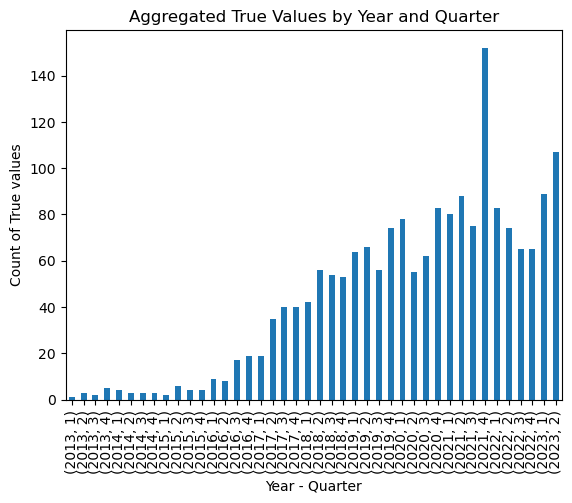

In [33]:
import matplotlib.pyplot as plt

num_rows = merged_data.shape[0]
print('total citations true:', num_rows)

merged_data["Start Date"] = pd.to_datetime(merged_data["Start Date"])

merged_data["Year"] = merged_data["Start Date"].dt.year
merged_data["Quarter"] = merged_data["Start Date"].dt.quarter

aggregated_data = merged_data.groupby(["Year", "Quarter"])["AI_term"].sum()
print(aggregated_data)

# Plot the data as a bar chart
aggregated_data.plot(kind="bar")

# Set the labels and title
plt.xlabel("Year - Quarter")
plt.ylabel("Count of True values")
plt.title("Aggregated True Values by Year and Quarter")

# Show the plot
plt.show()
